In [1]:
import pandas as pd
import numpy as np
import glob
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

In [2]:
import imblearn
from imblearn.over_sampling import SMOTE 

In [3]:
start_time = time.time() 

In [4]:
asteroid_df = pd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df.drop(columns = ['diameter', 'albedo', 'a', 'i', 'neo'], inplace = True)
asteroid_df

,pha,H,e,q,n,moid,spkid,full_name
0,0,-7.411043,-0.608738,0.289176,-0.009788,0.306452,20000001,1 Ceres (A801 AA)
1,0,-6.932515,0.859223,-0.382876,-0.017945,-0.258065,20000002,2 Pallas (A802 FA)
2,0,-6.282209,1.108738,-0.618740,0.181077,-0.564516,20000003,3 Juno (A804 RA)
3,0,-7.466258,-0.503883,-0.357027,0.928222,-0.403226,20000004,4 Vesta (A807 FA)
4,0,-5.171779,0.440777,-0.444265,0.384992,-0.451613,20000005,5 Astraea (A845 XA)
...,...,...,...,...,...,...,...,...
137912,0,-3.141104,8.195146,6.101777,-3.502333,6.048387,3547316,(2010 BK118)
137913,0,-0.319018,7.751456,2.129241,-3.470979,2.258065,3516402,(2010 GW64)
137914,0,-1.306748,8.038835,4.859451,-3.497338,5.290323,3517549,(2010 GW147)
137915,0,-0.503067,7.960194,0.447496,-3.476215,0.903226,3523334,(2010 JH124)


## Split data

In [5]:
exclude_col = ['pha', 'spkid', 'full_name']
X = asteroid_df.drop(columns = exclude_col)
y = asteroid_df.iloc[:, 0]

In [6]:
from sklearn.model_selection import train_test_split
X_train_original, X_test, y_train_original, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [7]:
sm = SMOTE(random_state = 42) 
X_train, y_train = sm.fit_resample(X_train_original, y_train_original.ravel())
  
print("After OverSampling, counts of label 'N': {}".format(sum(y_train == 0))) 
print("After OverSampling, counts of label 'Y': {}".format(sum(y_train == 1))) 

After OverSampling, counts of label 'N': 110091
After OverSampling, counts of label 'Y': 110091


C:\Users\stack\AppData\Local\Temp\ipykernel_26516\1833696101.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train, y_train = sm.fit_resample(X_train_original, y_train_original.ravel())


## Grid Search

tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 25]},
                    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 25]}]

score = 'accuracy'

print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                   scoring=score, n_jobs = -2, verbose = 4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
results = clf.cv_results_
for i in range(len(results["params"])):
    print("%0.3f (+/-%0.03f) for %r" % (results["mean_test_score"][i], results["std_test_score"][i] * 2, results["params"][i]))

Grid Search was not possible, execution never stopped
Used parameters from 'Dask' option just to finish the code

In [8]:
from sklearn.model_selection import GridSearchCV
clf_best = SGDClassifier(l1_ratio = 0.5, loss = 'modified_huber', max_iter= 300, penalty = 'l2')

### Model validation via cross-validation

In [9]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

sm = SMOTE(random_state = 42) 
X1, y1 = sm.fit_resample(X1, y1.ravel())
X2, y2 = sm.fit_resample(X2, y2.ravel())

# fit the model on one set of data
clf_best.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = clf_best.predict(X2)
accuracy_score(y2, y2_model)

C:\Users\stack\AppData\Local\Temp\ipykernel_26516\4248052984.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X1, y1 = sm.fit_resample(X1, y1.ravel())
C:\Users\stack\AppData\Local\Temp\ipykernel_26516\4248052984.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X2, y2 = sm.fit_resample(X2, y2.ravel())


0.9963375819320709

In [10]:
y2_model = clf_best.fit(X1, y1).predict(X2)
y1_model = clf_best.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.9965913220437532, 0.9963739154446495)

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf_best, X, y, cv=5)

array([0.99786108, 0.99793358, 0.9982598 , 0.99844107, 0.9798064 ])

In [12]:
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.over_sampling import SMOTE

pipeline = Pipeline([
    ('smote', SMOTE()),                 
    ('SGDClassifier', clf_best)     
])

scores = cross_val_score(pipeline, X, y, cv=5)
print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99960122 1.         1.         1.         0.97810245]
Mean accuracy: 0.9955407345015546


In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=skf)

res = [clf_best.fit(X.iloc[train], y.iloc[train]).score(X.iloc[test], y.iloc[test]) for train, test in skf.split(X, y)]
#res is a score vector within 0,1
np.mean(res) #The average accuracy
print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99706352 0.99724478 0.9969909  0.99753471 0.99728093]
Mean accuracy: 0.9972229684349443


## Cross Validation without KFold

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)  
scores = cross_val_score(pipeline, X, y, cv=kf)

print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99728103 0.99709977 0.99793351 0.99713592 0.99720843]
Mean accuracy: 0.9973317305528735


## Validation Curve (for a Single Hyperparameter)

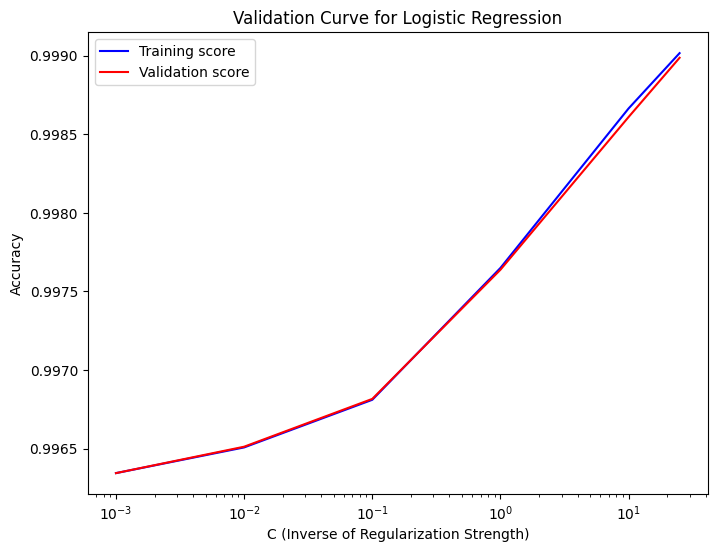

In [15]:
from sklearn.model_selection import validation_curve

para = {'C': [0.001, 0.01, 0.1, 1, 10, 25]} 
param_range = para['C']

train_scores, val_scores = validation_curve(
    SVC(),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation score", color="red")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve for Logistic Regression")
plt.xscale("log")  # Log scale for C
plt.legend()
plt.show()

## Learning Curves (Training vs. Cross-Validation Performance)

C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\linear_model\_

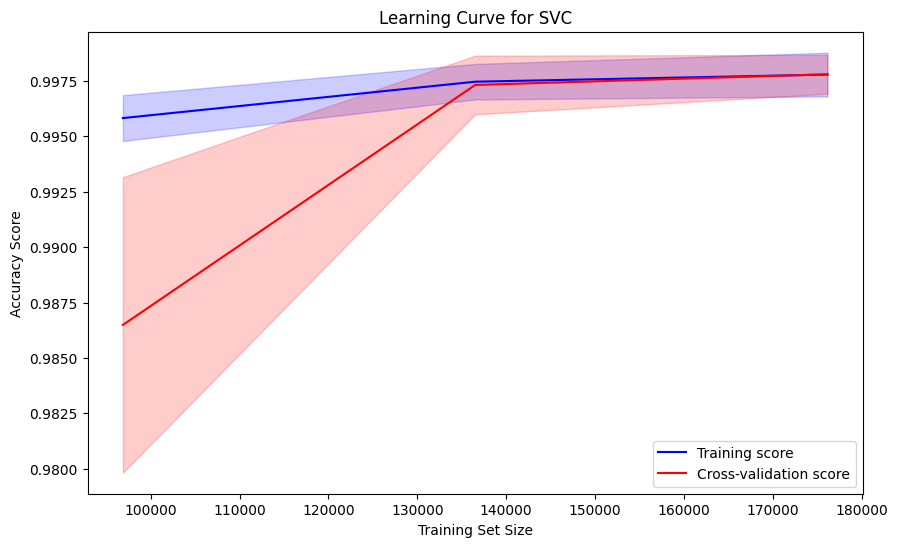

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    clf_best, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5)
)

# Mean and standard deviation for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, label="Cross-validation score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve for SVC")
plt.legend()
plt.show()

In [17]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 2659.00 seconds
